In [1]:
!pip install git+https://github.com/desi-bgs/bgs-cmxsv.git --upgrade --user

  Cloning https://github.com/desi-bgs/bgs-cmxsv.git to /tmp/pip-req-build-dc6_7k1i
  Running command git clone -q https://github.com/desi-bgs/bgs-cmxsv.git /tmp/pip-req-build-dc6_7k1i
  Created wheel for bgs-sv: filename=bgs_sv-0.0-py3-none-any.whl size=1086170 sha256=a4e6de500452a04d452344fc9d472acaffd9ada8467734fdb7a21691faf8a984
  Stored in directory: /tmp/pip-ephem-wheel-cache-fo2jcu6k/wheels/c5/7b/33/3fa8f7338087a37e7ad7a1378e08d97458e5dbab577a10268f
Successfully built bgs-sv
  Attempting uninstall: bgs-sv
    Found existing installation: bgs-sv 0.0
    Uninstalling bgs-sv-0.0:
      Successfully uninstalled bgs-sv-0.0


In [2]:
import os
import h5py
import fitsio
import numpy as np 
import scipy as sp
import astropy.table as atable
import astropy.units as u
import matplotlib.pyplot as plt

from bgs_sv import sv1

In [3]:
from scipy.ndimage import gaussian_filter1d
def smooth_sky(sky, smoothing=100.): 
    return gaussian_filter1d(sky, smoothing) 

In [4]:
fsky = 'sv1.bright_exps.20210217.Isky.npy'
fwave = 'sv1.bright_exps.20210217.wave.npy'
fobscond = 'sv1.bright_exps.20210217.obs_cond.hdf5'

if not np.all([os.path.isfile(_f) for _f in [fsky, fwave, fobscond]]): 
    # read in Aaron's GFA data of exposures through 2021/02/01
    gfa = atable.Table.read('/global/cfs/cdirs/desi/users/ameisner/GFA/conditions/offline_matched_coadd_ccds_SV1-thru_20210215.fits')['NIGHT', 'EXPID', 'AIRMASS', 'SKY_MAG_AB', 'MOON_ILLUMINATION', 'MOON_SEP_DEG', 'MOON_ZD_DEG', 'TRANSPARENCY']
    exps = gfa.group_by(['EXPID']).groups.aggregate(np.median)
    
    nominal_dark = 21.07
    bright_lim = nominal_dark - 2.5 * np.log10(2.5)

    is_bright = (exps['SKY_MAG_AB'] <= bright_lim)
    print('%i of %i exposures are during bright time' % (np.sum(is_bright), len(exps)))
    bright_exps = exps[is_bright]
    
    # get sky surface brightnesses
    Iskies = []
    for i in np.arange(len(bright_exps)):
        wave, Isky = sv1.get_obs_sky(int(bright_exps[i]['NIGHT']), int(bright_exps[i]['EXPID']), 'model', redux="daily");
        Iskies.append(Isky * 1e17)

    # only keep exposures where we have sky data
    Iskies = np.array(Iskies)

    has_sky = (np.sum(np.array(Iskies), axis=1) > 0.)

    bright_exps = bright_exps[has_sky]
    Iskies = Iskies[has_sky,:]

    # save observing conditions and sky fluxes to file
    bright_exps.write(fobscond, format='hdf5')
    np.save(fsky, Iskies)
    np.save(fwave, wave)
else: 
    bright_exps = atable.Table.read(fobscond, format='hdf5')
    Iskies = np.load(fsky)
    wave = np.load(fwave)
    
# observing conditions from median value of the GFAs
airmass = bright_exps['AIRMASS']
moon_frac = bright_exps['MOON_ILLUMINATION']
moon_sep = bright_exps['MOON_SEP_DEG']
moon_alt = 90. - bright_exps['MOON_ZD_DEG']
transp = bright_exps['TRANSPARENCY']

In [5]:
dir_cmx = '/global/cfs/cdirs/desi/users/chahah/bgs_exp_coadd/'
dir_sky = '/global/cfs/cdirs/desi/users/chahah/sky/'

def read_cmx_skies(): 
    ''' read CMX sky fibers and return median sky surface brightness measurements for each exposure
    '''
    #fsky = h5py.File(os.path.join(dir_cmx, 'sky_fibers.coadd_gfa.minisv2_sv0.hdf5'), 'r')
    fsky = h5py.File(os.path.join(dir_cmx, 'sky_fibers.cmx.v1.hdf5'), 'r')
    
    sky_data = {}
    for k in fsky.keys():
        sky_data[k] = fsky[k][...]
    
    bad_seeing = (sky_data['tileid'] == 70502) | (sky_data['date'] == 20200314) #bad seeing on Feb 25 and 27

    exp_cuts = ~bad_seeing

    for k in sky_data.keys(): 
        if 'wave' not in k: 
            sky_data[k] = sky_data[k][exp_cuts]
        else:
            sky_data[k] = sky_data[k]
            
    uniq_exps, i_uniq = np.unique(sky_data['expid'], return_index=True)

    # compile median observing conditions for each unique exposure and
    # get the median sky fluxes of all sky fibers
    sky_uniq_exps = {} 
    for k in ['date', 'tileid', 'expid', 
              'airmass', 'moon_ill', 'moon_alt', 'moon_sep', 
              'sun_alt', 'sun_sep', 'exptime', 'transparency']: 
        sky_uniq_exps[k] = np.zeros(len(uniq_exps))

    sky_uniq_exps['wave_b'] = sky_data['wave_b']
    sky_uniq_exps['wave_r'] = sky_data['wave_r']
    sky_uniq_exps['wave_z'] = sky_data['wave_z']
    
    sky_uniq_exps['sky_b'] = np.zeros((len(uniq_exps), len(sky_data['wave_b'])))
    sky_uniq_exps['sky_r'] = np.zeros((len(uniq_exps), len(sky_data['wave_r'])))
    sky_uniq_exps['sky_z'] = np.zeros((len(uniq_exps), len(sky_data['wave_z'])))
    
    print('date \t\t tile \t exp \t texp \t airmass \t moon_ill \t moon_alt \t moon_sep')
    for _i, _i_uniq, _exp in zip(range(len(i_uniq)), i_uniq, uniq_exps): 
        _is_exp = (sky_data['expid'] == _exp)

        sky_uniq_exps['date'][_i] = sky_data['date'][_i_uniq]
        sky_uniq_exps['tileid'][_i] = sky_data['tileid'][_i_uniq]
        sky_uniq_exps['expid'][_i] = sky_data['expid'][_i_uniq]
        sky_uniq_exps['airmass'][_i] = np.median(sky_data['airmass'][_is_exp])
        sky_uniq_exps['moon_ill'][_i] = np.median(sky_data['moon_ill'][_is_exp])
        sky_uniq_exps['moon_alt'][_i] = np.median(sky_data['moon_alt'][_is_exp])
        sky_uniq_exps['moon_sep'][_i] = np.median(sky_data['moon_sep'][_is_exp])
        sky_uniq_exps['transparency'][_i] = np.median(sky_data['transparency'][_is_exp])

        sky_uniq_exps['exptime'][_i] = sky_data['exptime'][_is_exp][0]

        sky_uniq_exps['sun_alt'][_i] = np.median(sky_data['sun_alt'][_is_exp])
        sky_uniq_exps['sun_sep'][_i] = np.median(sky_data['sun_sep'][_is_exp])        
        #sky_uniq_exps['sky_b'][_i] = np.median(sky_data['sky_b'][_is_exp], axis=0) 
        #sky_uniq_exps['sky_r'][_i] = np.median(sky_data['sky_r'][_is_exp], axis=0) 
        #sky_uniq_exps['sky_z'][_i] = np.median(sky_data['sky_z'][_is_exp], axis=0)

        sky_uniq_exps['sky_b'][_i] = np.median(sky_data['sky_sb_b'][_is_exp], axis=0) 
        sky_uniq_exps['sky_r'][_i] = np.median(sky_data['sky_sb_r'][_is_exp], axis=0) 
        sky_uniq_exps['sky_z'][_i] = np.median(sky_data['sky_sb_z'][_is_exp], axis=0)

        print('%i \t %i \t %i \t %.f \t %.2f \t\t %.2f \t\t %.1f \t\t %f' % 
              (sky_data['date'][_i_uniq], sky_data['tileid'][_i_uniq], sky_data['expid'][_i_uniq], 
               sky_uniq_exps['exptime'][_i], 
               sky_uniq_exps['airmass'][_i], sky_uniq_exps['moon_ill'][_i], 
               sky_uniq_exps['moon_alt'][_i], sky_uniq_exps['moon_sep'][_i]))

    return sky_uniq_exps

def read_BOSS_skies(): 
    ''' read sky fibers from BOSS
    '''
    f_boss = os.path.join(dir_sky, 'Bright_BOSS_Sky_blue.fits')
    boss = fitsio.read(f_boss)    
    f_red = os.path.join(dir_sky, 'Bright_BOSS_Sky_red.fits')
    red = fitsio.read(f_red)
    
    sky_boss = {} 
    sky_boss['airmass'] = boss['AIRMASS']
    sky_boss['moon_ill'] = boss['MOON_ILL']
    sky_boss['moon_alt'] = boss['MOON_ALT']
    sky_boss['moon_sep'] = boss['MOON_SEP']

    sky_boss['sun_alt'] = boss['SUN_ALT']
    sky_boss['sun_sep'] = boss['SUN_SEP']
        
    boss_fiber_area = np.pi

    sky_boss['wave_b'] = boss['WAVE'] * 10. # convert to Angstroms
    sky_boss['sky_b'] = boss['SKY'] / boss_fiber_area
    sky_boss['wave_r'] = red['WAVE'] * 10.
    sky_boss['sky_r'] = red['SKY'] / boss_fiber_area
    return sky_boss

In [6]:
_cmx_skies = read_cmx_skies()

# apply transparency cut 
transp_cut = (_cmx_skies['transparency'] > 0.9)

cmx_skies = {} 
for k in _cmx_skies.keys():
    if k not in ['wave_b', 'wave_r', 'wave_z']: 
        cmx_skies[k] = _cmx_skies[k][transp_cut]
    else: 
        cmx_skies[k] = _cmx_skies[k]
        
boss_skies = read_BOSS_skies()

# remove twilight
twilight = boss_skies['sun_alt'] > -15.
print('%i of %i are twilight' % (np.sum(twilight), len(boss_skies['sun_alt'])))

for k in boss_skies.keys():
    boss_skies[k] = boss_skies[k][~twilight]

date 		 tile 	 exp 	 texp 	 airmass 	 moon_ill 	 moon_alt 	 moon_sep
20200303 	 70500 	 52932 	 500 	 1.15 		 0.65 		 35.8 		 34.692321
20200303 	 70500 	 52934 	 500 	 1.19 		 0.65 		 31.0 		 34.557860
20200303 	 70500 	 52936 	 500 	 1.25 		 0.65 		 26.2 		 34.423687
20200303 	 70500 	 52938 	 500 	 1.31 		 0.65 		 21.6 		 34.292890
20200303 	 70500 	 52940 	 500 	 1.39 		 0.65 		 17.0 		 34.162246
20200303 	 70500 	 52942 	 500 	 1.49 		 0.66 		 12.2 		 34.026271
20200304 	 70510 	 53078 	 500 	 1.43 		 0.74 		 55.8 		 79.209427
20200304 	 70510 	 53080 	 500 	 1.34 		 0.75 		 52.1 		 79.061903
20200304 	 70510 	 53081 	 500 	 1.29 		 0.75 		 49.2 		 78.944160
20200304 	 70510 	 53082 	 500 	 1.24 		 0.75 		 46.4 		 78.827312
20200304 	 70510 	 53083 	 500 	 1.19 		 0.75 		 43.5 		 78.710167
20200304 	 70510 	 53084 	 500 	 1.16 		 0.75 		 40.7 		 78.593746
20200304 	 70510 	 53085 	 500 	 1.13 		 0.75 		 37.8 		 78.477009
20200304 	 70510 	 53086 	 500 	 1.10 		 0.75 		 34.9 		 78.

[]

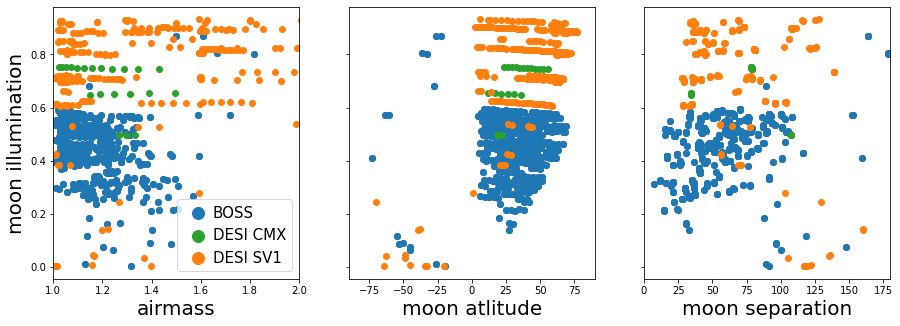

In [7]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(boss_skies['airmass'], boss_skies['moon_ill'], c='C0', label='BOSS')
sub.scatter(cmx_skies['airmass'], cmx_skies['moon_ill'], c='C2', label='DESI CMX')
sub.scatter(airmass, moon_frac, c='C1', label='DESI SV1')
sub.legend(loc='lower right', frameon=True, handletextpad=0, markerscale=2, fontsize=15)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('moon illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(boss_skies['moon_alt'], boss_skies['moon_ill'], c='C0')
sub.scatter(cmx_skies['moon_alt'], cmx_skies['moon_ill'], c='C2')
sub.scatter(moon_alt, moon_frac, c='C1')
sub.set_xlabel('moon atlitude', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])

sub = fig.add_subplot(133)
sub.scatter(boss_skies['moon_sep'], boss_skies['moon_ill'], c='C0', label='BOSS')
sub.scatter(cmx_skies['moon_sep'], cmx_skies['moon_ill'], c='C2', label='DESI CMX')
sub.scatter(moon_sep, moon_frac, c='C1')
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])

In [8]:
# sky brightness at 5000A for SV1
sv1_Iskies5000 = [] 
for Isky in Iskies: 
    Ismooth = smooth_sky(Isky, smoothing=100.)
    sv1_Iskies5000.append(np.interp(5000, wave, Ismooth))
    
# sky brightness at 5000A for CMX
cmx_Iskies5000 = []
for Isky in cmx_skies['sky_b']: 
    Ismooth = smooth_sky(Isky, smoothing=100.)
    cmx_Iskies5000.append(np.interp(5000, cmx_skies['wave_b'], Ismooth))
    
# sky brightness for BOSS
boss_Iskies5000 = []
for _w, Isky in zip(boss_skies['wave_b'], boss_skies['sky_b']): 
    Ismooth = smooth_sky(Isky, smoothing=800) # BOSS has 8x smaller binning
    boss_Iskies5000.append(np.interp(5000, _w, Ismooth))

In [9]:
airmass_all = np.concatenate([airmass, cmx_skies['airmass'], boss_skies['airmass']])
moon_frac_all = np.concatenate([moon_frac, cmx_skies['moon_ill'], boss_skies['moon_ill']])
moon_alt_all = np.concatenate([moon_alt, cmx_skies['moon_alt'], boss_skies['moon_alt']])
moon_sep_all = np.concatenate([moon_sep, cmx_skies['moon_sep'], boss_skies['moon_sep']])

Iskies5000_all = np.concatenate([sv1_Iskies5000, cmx_Iskies5000, boss_Iskies5000])

In [10]:
import desisim.simexp
from desimodel.io import load_throughput
from specsim import atmosphere as Atmosphere

In [11]:
config = desisim.simexp._specsim_config_for_wave(wave, dwave_out=0.8, specsim_config_file='desi')
atms = Atmosphere.initialize(config)

In [12]:
Isky_dark = atms.surface_brightness

In [13]:
def extinction(airmass, moonill, moonalt, moonsep): 
    atms.airmass = airmass
    return atms.extinction

def Isky_KS(airmass, moonill, moonalt, moonsep): 
    atms.airmass = airmass
    atms.moon.moon_phase = np.arccos(2.*moonill - 1)/np.pi
    atms.moon.moon_zenith = (90. - moonalt) * u.deg
    atms.moon.separation_angle = moonsep * u.deg
    return atms.surface_brightness

def Imoon_KS(airmass, moonill, moonalt, moonsep): 
    atms.airmass = airmass
    atms.moon.moon_phase = np.arccos(2.*moonill - 1)/np.pi
    atms.moon.moon_zenith = (90. - moonalt) * u.deg
    atms.moon.separation_angle = moonsep * u.deg
    return atms.moon.surface_brightness.to(1e-17 * u.erg / u.Angstrom / u.arcsec**2 / u.cm**2 / u.s)

In [14]:
Iskies_KS = np.array([Isky_KS(airmass_all[i], moon_frac_all[i], moon_alt_all[i], moon_sep_all[i]) for i in range(len(airmass_all))])
Iskies_moon_KS = np.array([Imoon_KS(airmass_all[i], moon_frac_all[i], moon_alt_all[i], moon_sep_all[i]) for i in range(len(airmass_all))])

In [15]:
Iskies5000_KS = []
for Isky in Iskies_KS: 
    Ismooth = smooth_sky(Isky, smoothing=100)
    Iskies5000_KS.append(np.interp(5000, wave, Ismooth))

(0.0, 25.0)

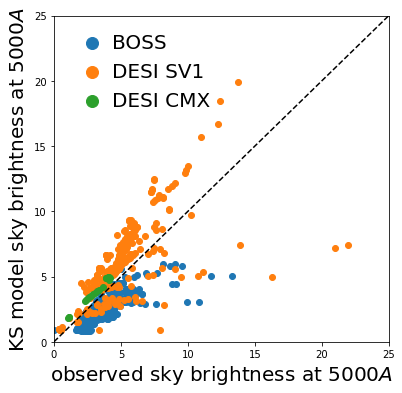

In [16]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.scatter(Iskies5000_all[len(airmass)+len(cmx_skies['airmass']):len(airmass)+len(cmx_skies['airmass'])+len(boss_skies['airmass'])], Iskies5000_KS[len(airmass)+len(cmx_skies['airmass']):len(airmass)+len(cmx_skies['airmass'])+len(boss_skies['airmass'])], c='C0', label='BOSS')
sub.scatter(Iskies5000_all[:len(airmass)], Iskies5000_KS[:len(airmass)], c='C1', label='DESI SV1')
sub.scatter(Iskies5000_all[len(airmass):len(airmass)+len(cmx_skies['airmass'])], Iskies5000_KS[len(airmass):len(airmass)+len(cmx_skies['airmass'])], c='C2', label='DESI CMX')

sub.plot([0, 40], [0, 40], c='k', ls='--')
sub.legend(loc='upper left', markerscale=2, handletextpad=0, frameon=False, fontsize=20)
sub.set_xlabel('observed sky brightness at $5000A$', fontsize=20)
sub.set_xlim(0., 25)
sub.set_ylabel('KS model sky brightness at $5000A$', fontsize=20)
sub.set_ylim(0., 25)

<ipython-input-17-ff37f256bb0f>:1: RuntimeWarning: divide by zero encountered in true_divide
  outliers = (Iskies5000_KS / Iskies5000_all < 0.8)
No handles with labels found to put in legend.


sky model underpredicts by >20percent for 939 of 1383 exposures


[]

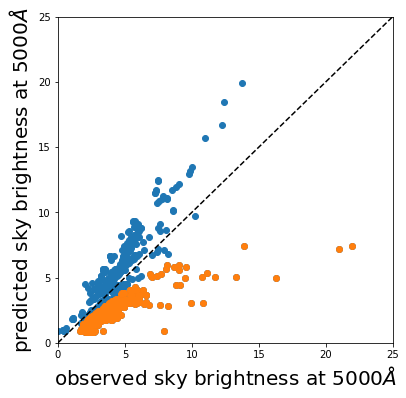

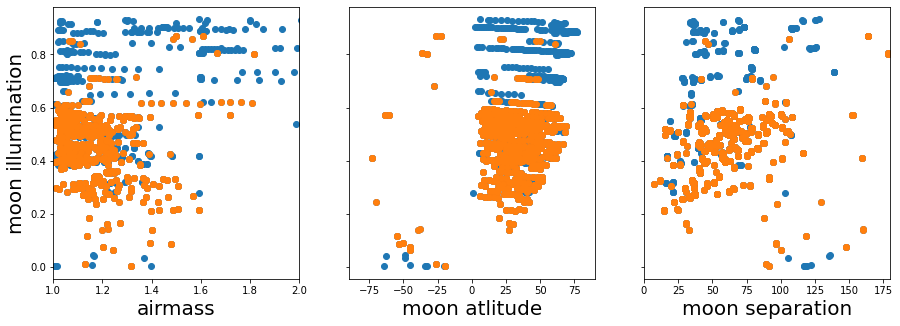

In [17]:
outliers = (Iskies5000_KS / Iskies5000_all < 0.8)
print('sky model underpredicts by >20percent for %i of %i exposures' % (np.sum(outliers), len(outliers)))

fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)

sub.scatter(Iskies5000_all, Iskies5000_KS)
sub.scatter(Iskies5000_all[outliers], np.array(Iskies5000_KS)[outliers])

sub.plot([0., 40.], [0., 40.], c='k', ls='--')
sub.legend(loc='upper left', markerscale=2, handletextpad=0, frameon=False, fontsize=20)
sub.set_xlabel('observed sky brightness at $5000\AA$', fontsize=20) 
sub.set_xlim([0., 25.])
sub.set_ylabel('predicted sky brightness at $5000\AA$', fontsize=20)
sub.set_ylim([0., 25.])



fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(airmass_all, moon_frac_all, c='C0')
sub.scatter(airmass_all[outliers], moon_frac_all[outliers], c='C1')
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('moon illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(moon_alt_all, moon_frac_all, c='C0')
sub.scatter(moon_alt_all[outliers], moon_frac_all[outliers], c='C1')
sub.set_xlabel('moon atlitude', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])

sub = fig.add_subplot(133)
sub.scatter(moon_sep_all, moon_frac_all, c='C0')
sub.scatter(moon_sep_all[outliers], moon_frac_all[outliers], c='C1')
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])